# BASICS 02 - Training the network

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../HOTS'

/home/INT/grimaldi.a/Documents/projets/HOTS/newhots/HOTS


## Loading events

In [2]:
import tonic.datasets as datasets
import tonic.transforms as transforms
from torch.utils.data import SubsetRandomSampler, DataLoader
from torch import Generator
import numpy as np

def get_loader(train = True, kfold = None, kfold_ind = 0, num_workers = 0):
    # creates a loader for the samples of the dataset. If kfold is not None, 
    # then the dataset is splitted into different folds with equal repartition of the classes.
    # works for NMNIST
    dataset = datasets.POKERDVS(save_to='../../Data',
                                    train=train, 
                                    transform = transforms.NumpyAsType(int))
    if kfold:
        subset_indices = []
        subset_size = len(dataset)//kfold
        for i in range(len(dataset.classes)):
            all_ind = np.where(np.array(dataset.targets)==i)[0]
            subset_indices += all_ind[kfold_ind*subset_size//len(dataset.classes):
                            min((kfold_ind+1)*subset_size//len(dataset.classes), len(dataset)-1)].tolist()
        g_cpu = Generator()
        g_cpu.manual_seed(42)
        subsampler = SubsetRandomSampler(subset_indices, g_cpu)
        loader = DataLoader(dataset, batch_size=1, shuffle=False, sampler=subsampler, num_workers = num_workers)
    else:
        loader = DataLoader(dataset, shuffle=True, num_workers = num_workers)
    return loader, dataset.ordering, dataset.classes

In [3]:
loader, order, classes = get_loader()
print(f'Size of Dataloader: {len(loader)} samples')

Size of Dataloader: 48 samples


## Network definition and training

loading a network with name:
 ../Records/models/2021-11-25_poker_homhots_[2, 1]_[4, 8, 16]_[0.7, 1.4, 2.8]_[2, 4, 8].pkl


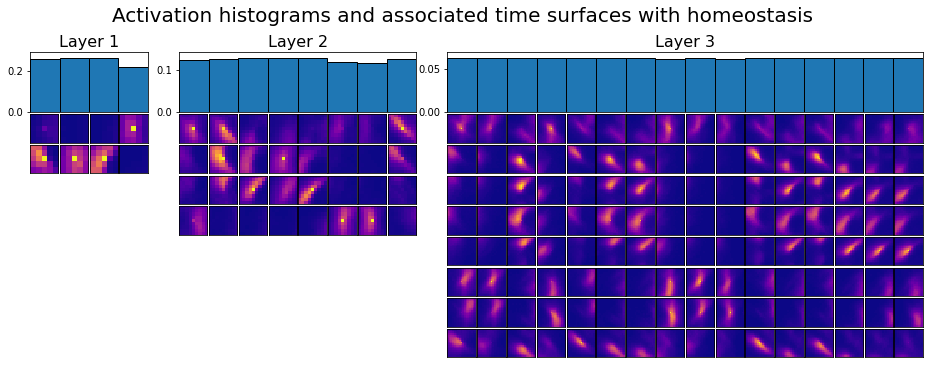

In [4]:
from Network import network
hots = network(name = 'homhots', tau = [0.7, 1.4, 2.8], homeo = [2,1], 
               timestr = '2021-11-25_poker')
events, target, indices = hots.running(loader, order, classes, learn=True)
hots.plotlayer();

loading a network with name:
 ../Records/models/2021-11-25_poker_hots_None_[4, 8, 16]_[0.7, 1.4, 2.8]_[2, 4, 8].pkl


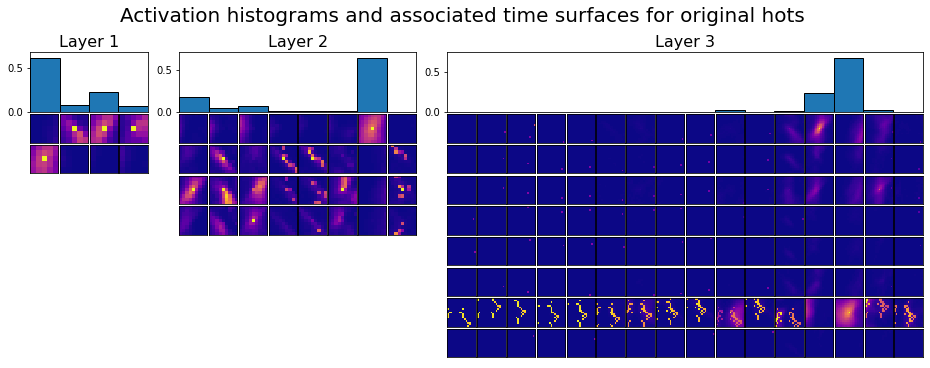

In [5]:
hots = network(name = 'hots', tau = [0.7, 1.4, 2.8],  
               timestr = '2021-11-25_poker')
hots.running(loader, order, classes, learn=True)
hots.plotlayer();

## Running network
### Training set

In [7]:
hots = network(name = 'homhots', tau = [0.7, 1.4, 2.8], homeo = [2,1], 
               timestr = '2021-11-25_poker')
hots, loaded = hots.load_model()
events, target, indices = hots.running(loader, order, classes)

loading a network with name:
 ../Records/models/2021-11-25_poker_homhots_[2, 1]_[4, 8, 16]_[0.7, 1.4, 2.8]_[2, 4, 8].pkl


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [01:49<00:00,  2.29s/it]


In [13]:
from Tools import save_output
output = [events, target, indices]
train = True 
nb = len(loader)
jitonic = None
save_output(hots, output, train, nb, jitonic)

### Testing set

In [12]:
loader, order, classes = get_loader(train=False)
print(f'Size of Dataloader: {len(loader)} samples')

  0%|          | 0/311022 [00:00<?, ?it/s]

Extracting ../../Data/POKERDVS/pips_test.tar.gz to ../../Data/POKERDVS
Size of Dataloader: 20 samples


In [14]:
output = hots.running(loader, order, classes)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:49<00:00,  2.46s/it]


In [15]:
train = False 
nb = len(loader)
save_output(hots, output, train, nb, jitonic)

# TODO:
- find an entropy measure for the (not histograms) kernels -> then method to get hom_param (+ measure of the balance between strengh of the gain and homeostasis)
- find a way to tune the hyper-parameters as a function of the signal
- make a good recordings of the network characterisitics during learning (check for STDP, loss, weight update strengh)
- think about how to save/output data (tonic format -> easy to use and exchange)
- have some easy to implement methods for:
    - training a network
        - unsupervised (done)
        - supervised
    - running a network (ouptut is classification result or stream of events, make a flag for the last layer)
    - learning rule for the classification layer (spiking mechanism==same as in HOTS)
    - get results of the paper:
        - online classification results
        - histogram classification 
        - adding jitter
- try the averaged time surface to separate movement and object
- try to add a threshold
- try with alpha instead of exponential decay
- what happens with sigma
- try to make a stride within the network